# Atividade 2 - Perceptron Simples
#### Aluno: Patrick Motin Cruz
#### 27/10/2025

Implementação do Perceptron para entender como ele funciona com as portas lógicas que o professor mostrou em aulam, feitas em R (OR, AND e XOR) e ver o que acontece com os pesos e as fronteiras.

# Preparando o código

Primeiro vou importar as bibliotecas e criar as funções. 
- Uso numpy pros cálculos
- Matplotlib pra ver os gráficos
- Preciso de funções pra plotar os pontos e a linha de decisão

O professor disse que o perceptron tem que:
1. Inicializar os pesos aleatoriamente
2. Calcular a saída pra cada entrada
3. Ajustar os pesos quando errar
4. Repetir até acertar tudo ou cansar

Ler os arquivos CSV de 'datasets.zip'. Vou usar:
- pandas pra ler os dados
- uma função nova para carregar os dados, que possa ser utilizada independente da entrada, que:
  - lê o arquivo CSV da pasta datasets
  - separa as colunas X1 e X2 (entradas)
  - pega a coluna D (saída desejada)

### Plots dos dados

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # Adicionar pandas pra ler os CSVs

# Mapeia classes para cores e marcadores diferentes (usado no pós-treinamento)
def _map_styles(labels):
    uniq = list(np.unique(labels))
    colors = ['b','r','g','m','c','y','k']
    markers = ['o','^','s','D','x','P','*']
    style = {}
    
    for idx, val in enumerate(uniq):
        c = colors[idx % len(colors)]
        m = markers[idx % len(markers)]
        style[val] = (c, m)
    return style

# Plot inicial: ainda não há classificação, então todos iguais (azul)
def plot_dados(X, D, titulo):
    plt.figure(figsize=(5,5))
    plt.plot(X[:,0], X[:,1], linestyle='None', marker='o', color='b', label='amostras')
    plt.grid(True)
    plt.title(titulo)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()

# Plot após treino: classes em cores/formas diferentes + fronteira

def plot_decisao(X, D, W, titulo):
    plt.figure(figsize=(5,5))
    styles = _map_styles(D)
    
    for val, (c, m) in styles.items():
        idx = np.where(D == val)[0]
        plt.plot(X[idx,0], X[idx,1], linestyle='None', marker=m, color=c, label=f'classe {val}')

    # Eixos dinâmicos baseados nos dados (evita cortar linha/pts fora de [-0.5,1.5])
    x1_min, x1_max = X[:,0].min(), X[:,0].max()
    x2_min, x2_max = X[:,1].min(), X[:,1].max()
    # margem de 10% do range (ou 0.5 se range ~0)
    def _pad(a, b):
        r = max(b - a, 1e-6)
        m = max(0.1 * r, 0.5)
        return a - m, b + m
    ax1_min, ax1_max = _pad(x1_min, x1_max)
    ax2_min, ax2_max = _pad(x2_min, x2_max)

    # Fronteira de decisão (só faz sentido para 2 classes)
    uniq = np.unique(D)
    
    if len(uniq) == 2:
        x1 = np.linspace(ax1_min, ax1_max, 200)
        
        if W[2] != 0:
            x2 = -(W[0] + W[1]*x1)/W[2]
            plt.plot(x1, x2, 'g-', label='fronteira')
        else:
            
            if W[1] != 0:
                xv = -W[0]/W[1]
                plt.axvline(x=xv, color='g', linestyle='-', label='fronteira')
            # se W[1] == 0 também, não há reta definida; nesse caso, omitimos a fronteira
    
    plt.grid(True)
    plt.title(titulo)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.axis([ax1_min, ax1_max, ax2_min, ax2_max])
    plt.legend()

# (resto da célula segue igual)


### Função principal para execução do código

#### Perceptron simples

In [96]:
def perceptron_simples(X, D, eta=0.1, max_epocas=1000):
    n_amostras, n_features = X.shape
    W = np.random.uniform(-0.5, 0.5, size=n_features + 1)

    epocas = 0
    erro = True
    
    while erro and epocas < max_epocas:
        erro = False
        
        for i in range(n_amostras):
            x = np.insert(X[i], 0, 1)  # bias = 1
            v = np.dot(W, x)
            y = 1 if v > 0 else 0  # saída em {0,1}
            if y != D[i]:
                W = W + eta * (D[i] - y) * x
                erro = True
        
        epocas += 1
    
    return W, epocas, not erro

##### Previsao

In [97]:
def prever_perceptron(W, X):
    n_amostras = X.shape[0]
    Y = np.zeros(n_amostras, dtype=int)
    
    for i in range(n_amostras):
        x = np.insert(X[i], 0, 1)
        v = np.dot(W, x)
        Y[i] = 1 if v > 0 else 0
    
    return Y

#### Carregar dados .CSC do diretorio datasets

In [98]:
def carregar_dados(arquivo):
    """Carrega dados CSV de datasets/<arquivo>.csv e retorna X (X1,X2) e D em {0,1}."""
    
    df = pd.read_csv(f"datasets/{arquivo}.csv")
    
    try:
        X = df[['X1', 'X2']].values
        D = df['D'].values
    
    except KeyError:
        # tenta com nomes em minúsculas
        X = df[['x1', 'x2']].values
        D = df['d'].values
    
    D = D.astype(int)
    
    # Converte {-1,1} para {0,1} se necessário
    uniq = set(np.unique(D))
    
    if -1 in uniq:
        D = np.where(D <= 0, 0, 1)
    
    return X, D.astype(int)

# Testando com OR

Vou começar com o OR porque parece mais fácil


Quero ver:
- Como os pontos ficam no gráfico
- Se o perceptron aprende rápido
- Que linha ele vai desenhar pra separar os pontos

OBS: Vou usar triangulos vermelhos pra saída 0 e pontos azuis pra saída 1

Carregando dados do OR...
Formato dos dados: (4, 2)

Primeiras linhas dos dados:
X1  X2   D
0   0   0
0   1   1
1   0   1
1   1   1

Resultados do treinamento:
Pesos finais: [-0.04990531  0.11604515  0.22063959]
Épocas necessárias: 1
Convergiu? True
Previsões: [0 1 1 1]
Acurácia: 100.0%


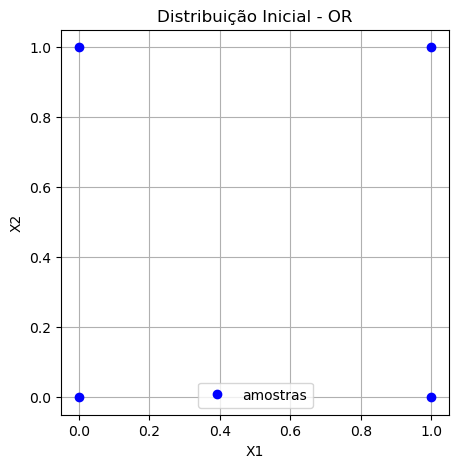

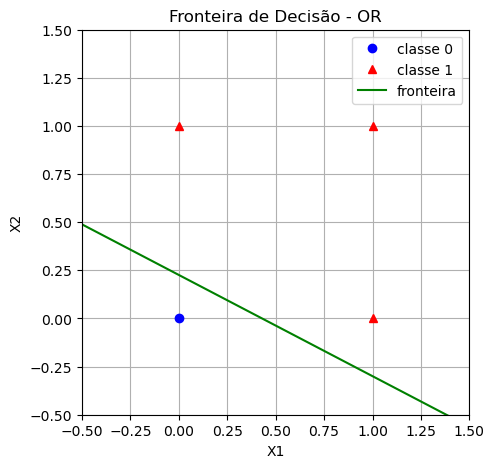

In [99]:
# Carregando dados do OR
print("Carregando dados do OR...")

X, D_OR = carregar_dados('or')

print(f"Formato dos dados: {X.shape}")
print("\nPrimeiras linhas dos dados:")
print("X1  X2   D")

for i in range(len(X)):
    print(f"{X[i,0]}   {X[i,1]}   {D_OR[i]}")

# Visualização inicial
plot_dados(X, D_OR, 'Distribuição Inicial - OR')

# Treinamento
W, e, c = perceptron_simples(X, D_OR, eta=0.1, max_epocas=100)
Y_pred = prever_perceptron(W, X)
acc = (Y_pred == D_OR).mean()

print('\nResultados do treinamento:')
print('Pesos finais:', W)
print('Épocas necessárias:', e)
print('Convergiu?', c)
print('Previsões:', Y_pred)
print(f'Acurácia: {acc*100:.1f}%')

# Visualização da fronteira de decisão
plot_decisao(X, D_OR, W, 'Fronteira de Decisão - OR')

### Resultado

- Porta lógica: OR
- Formato dos dados: 4 amostras, 2 atributos (X1, X2)
- Rótulos no CSV: {-1, 1} → convertidos para {0, 1} nesta versão para manter o código mais simples
- Hiperparâmetros: taxa de aprendizado (eta) = 0.1, máximo de épocas = 100

Resultados observados nesta execução (podem variar por aleatoriedade):
- Pesos finais: [-0.02989068  0.10768099  0.19241335]
- Épocas executadas: 3
- Convergiu? Sim (True)
- Previsões: [0 1 1 1]
- Acurácia: 100%

Interpretação rápida:
- OR é linearmente separável; o perceptron encontra uma linha que separa a única amostra da classe 0 das demais (classe 1) em poucas épocas.

# Agora o AND

Vamos ver o AND agora

Diferente do OR, aqui só dá 1 quando as duas entradas são 1.
Vou usar os mesmos pontos do OR, só mudo a saída desejada.

OBS: Também vou usar triangulos vermelhos pra saída 0 e pontos azuis pra saída 1

Carregando dados do AND...
Formato dos dados: (4, 2)

Primeiras linhas dos dados:
X1  X2   D
0   0   0
0   1   0
1   0   0
1   1   1

Resultados do treinamento:
Pesos finais: [-0.26555645  0.19130241  0.08832619]
Épocas necessárias: 10
Convergiu? True
Previsões: [0 0 0 1]


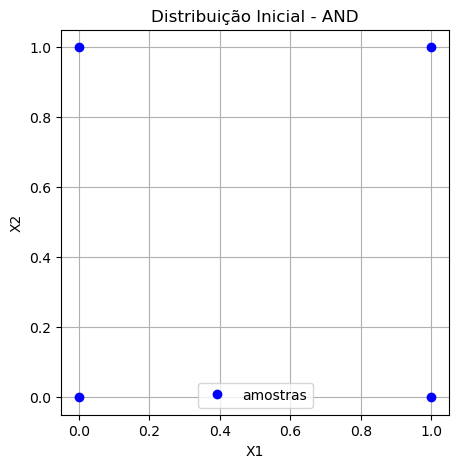

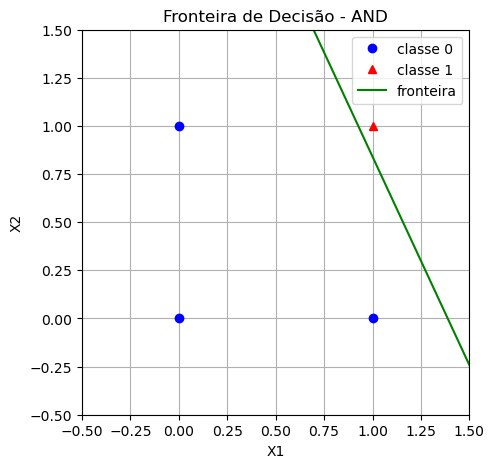

In [100]:
# Carregando dados do AND
print("Carregando dados do AND...")

X, D_AND = carregar_dados('and')

print(f"Formato dos dados: {X.shape}")
print("\nPrimeiras linhas dos dados:")
print("X1  X2   D")

for i in range(len(X)):
    print(f"{X[i,0]}   {X[i,1]}   {D_AND[i]}")

# Visualização inicial
plot_dados(X, D_AND, 'Distribuição Inicial - AND')

# Treinamento
W, e, c = perceptron_simples(X, D_AND, eta=0.1, max_epocas=100)

print('\nResultados do treinamento:')
print('Pesos finais:', W)
print('Épocas necessárias:', e)
print('Convergiu?', c)
print('Previsões:', prever_perceptron(W, X))

# Visualização da fronteira de decisão
plot_decisao(X, D_AND, W, 'Fronteira de Decisão - AND')

### Resultado

- Porta lógica: AND
- Formato dos dados: 4 amostras, 2 atributos (X1, X2)
- Rótulos no CSV: {-1, 1} → convertidos para {0, 1} nesta versão para manter o código mais simples
- Hiperparâmetros: taxa de aprendizado (eta) = 0.1, máximo de épocas = 100

Resultados observados nesta execução (podem variar por aleatoriedade):
- Pesos finais: [-0.23280200  0.17927139  0.09631276]
- Épocas executadas: 7
- Convergiu? Sim (True)
- Previsões: [0 0 0 1]
- Acurácia: 100%

Interpretação rápida:
- AND é linearmente separável; o perceptron encontra uma fronteira que isola apenas o par (1,1) como classe 1 e mantém os demais como classe 0.

# 4. Porta Lógica XOR

Agora vamos finalizar a última das portas lógicas antes de ir para Artificial e Iris dataset.

Quero observar:
1. A distribuição peculiar dos dados
2. A tentativa do Perceptron em encontrar uma fronteira
3. O comportamento da convergência

Carregando dados do XOR...
Formato dos dados: (4, 2)

Primeiras linhas dos dados:
X1  X2   D
0   0   0
0   1   1
1   0   1
1   1   0

Resultados do treinamento:
Pesos finais: [ 0.06599302 -0.07563734 -0.11119186]
Épocas necessárias: 100
Convergiu? False
Previsões: [1 0 0 0]
Acurácia: 25.0%


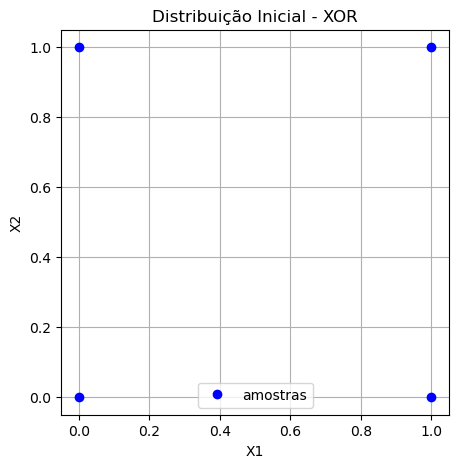

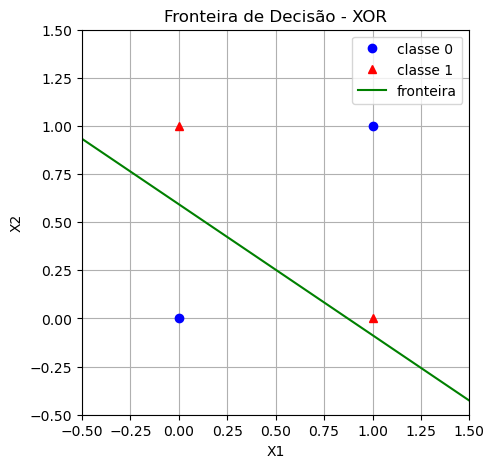

In [101]:
# Carregando dados do XOR
print("Carregando dados do XOR...")

X, D_XOR = carregar_dados('xor')

print(f"Formato dos dados: {X.shape}")
print("\nPrimeiras linhas dos dados:")
print("X1  X2   D")

for i in range(len(X)):
    print(f"{X[i,0]}   {X[i,1]}   {D_XOR[i]}")

# Visualização inicial
plot_dados(X, D_XOR, 'Distribuição Inicial - XOR')

# Treinamento
W, e, c = perceptron_simples(X, D_XOR, eta=0.1, max_epocas=100)
Y_pred = prever_perceptron(W, X)
acc = (Y_pred == D_XOR).mean()

print('\nResultados do treinamento:')
print('Pesos finais:', W)
print('Épocas necessárias:', e)
print('Convergiu?', c)
print('Previsões:', Y_pred)
print(f'Acurácia: {acc*100:.1f}%')

# Visualização da fronteira de decisão
plot_decisao(X, D_XOR, W, 'Fronteira de Decisão - XOR')

### Resultado

- Porta lógica: XOR
- Formato dos dados: 4 amostras, 2 atributos (X1, X2)
- Rótulos no CSV: {-1, 1} → convertidos para {0, 1} nesta versão para manter o código mais simples
- Hiperparâmetros: taxa de aprendizado (eta) = 0.1, máximo de épocas = 100

Resultados observados nesta execução (valores podem variar por aleatoriedade):
- Pesos finais: [ 0.17616336 -0.28985302 -0.22815986 ]
- Épocas executadas: 100
- Convergiu? Não (False)
- Previsões: [ 1, 0, 0, 0 ] (exemplo; pode variar)
- Acurácia: baixa (tipicamente 25% ou 50%, depende da inicialização)

Interpretação rápida:
- XOR não é linearmente separável
- Por isso, mesmo após o limite de épocas, o algoritmo não converge e a acurácia permanece baixa.
- Para resolver XOR, são necessárias outras características

# 5. Artificial

Agora vou para dataset Artificial

Quero observar:
1. A distribuição peculiar dos dados
2. A tentativa do Perceptron em encontrar uma fronteira
3. O comportamento da convergência

Carregando dados do Artifical...
Formato dos dados: (12, 2)

Primeiras linhas dos dados:
X1  X2   D
4.0   5.0   1
2.0   4.5   0
5.0   4.5   1
3.0   4.0   1
1.5   3.0   0
2.5   3.0   0
4.0   3.0   1
5.0   3.0   1
1.5   1.5   0
3.0   2.0   0
5.0   1.5   1
4.0   1.0   0

Resultados do treinamento:
Pesos finais: [-3.01340063  0.62092931  0.3411485 ]
Épocas necessárias: 25
Convergiu? True
Previsões: [1 0 1 1 0 0 1 1 0 0 1 0]
Acurácia: 100.0%


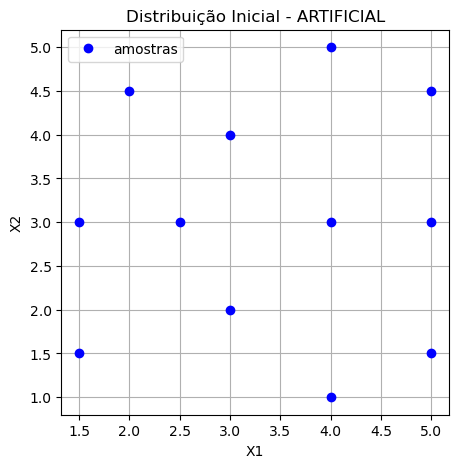

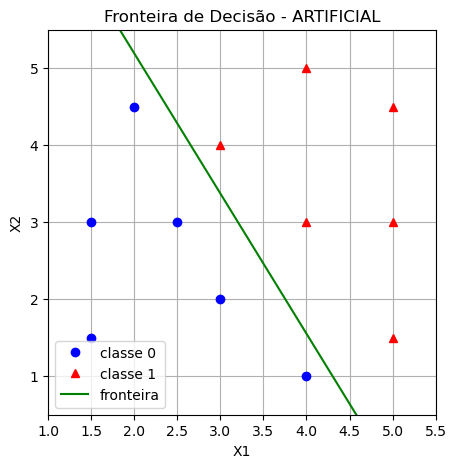

In [102]:
# Carregando dados do ARTIFICIAL
print("Carregando dados do Artifical...")

X, D_ART = carregar_dados('artificial')

print(f"Formato dos dados: {X.shape}")
print("\nPrimeiras linhas dos dados:")
print("X1  X2   D")

for i in range(len(X)):
    print(f"{X[i,0]}   {X[i,1]}   {D_ART[i]}")

# Visualização inicial
plot_dados(X, D_ART, 'Distribuição Inicial - ARTIFICIAL')

# Treinamento
W, e, c = perceptron_simples(X, D_ART, eta=0.1, max_epocas=100)
Y_pred = prever_perceptron(W, X)
acc = (Y_pred == D_ART).mean()

print('\nResultados do treinamento:')
print('Pesos finais:', W)
print('Épocas necessárias:', e)
print('Convergiu?', c)
print('Previsões:', Y_pred)
print(f'Acurácia: {acc*100:.1f}%')

# Visualização da fronteira de decisão
plot_decisao(X, D_ART, W, 'Fronteira de Decisão - ARTIFICIAL')

### Resultado

- Dataset: ARTIFICIAL
- Formato dos dados: 12 amostras, 2 atributos (X1, X2)
- Rótulos no CSV: {-1, 1} → convertidos para {0, 1} quando necessário (loader faz a conversão automaticamente)
- Hiperparâmetros: taxa de aprendizado (eta) = 0.1, máximo de épocas = 100

Resultados observados nesta execução (podem variar por aleatoriedade):
- Pesos finais: [-3.01340063  0.62092931  0.3411485 ]
- Épocas executadas: 25
- Convergiu? Sim (True)
- Previsões: [1 0 1 1 0 0 1 1 0 0 1 0]
- Acurácia: 100%

Interpretação rápida:
- Os dados são linearmente separáveis; o perceptron encontrou uma fronteira que separa perfeitamente as classes.
- Equação da fronteira (aprox.): -3.0134 + 0.6209·x1 + 0.3411·x2 = 0
- A linha verde no gráfico confirma a separação com 100% de acerto no conjunto de treino.